In [320]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, 
                                    GridSearchCV, RepeatedStratifiedKFold,
                                    StratifiedShuffleSplit
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

import imblearn
from imblearn.under_sampling import NearMiss

import itertools
import sys
import os

In [321]:
# helper functions from previous projects

ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    '''
        plt.savefig wrapper. refer to 
        https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.savefig.html
        
        Args:
            fig_name (str): name of the figrue
            tight_layout (bool): adjust subplot to fit in the figure area
            fig_extension (str): file format to save the figure in
            resolution (int): figure resolution
    '''
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Loading in the Data and High-level Analysis

In [322]:
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [372]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [363]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Saving figure histogram


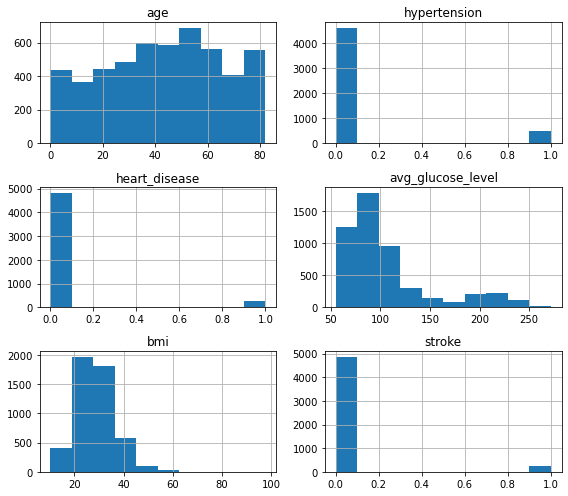

In [373]:
stroke_df.drop("id", axis=1).hist(figsize=(8,7))
save_fig("histogram")

Saving figure class imbalance


0    4861
1     249
Name: stroke, dtype: int64

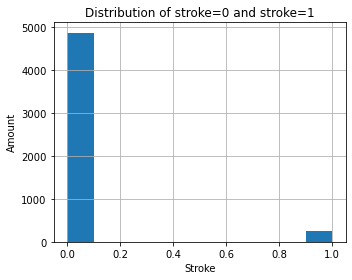

In [362]:
stroke_df["stroke"].hist(figsize=(5,4))
plt.xlabel("Stroke")
plt.ylabel("Amount")
plt.title("Distribution of stroke=0 and stroke=1")
save_fig("class imbalance")
stroke_df["stroke"].value_counts() # the data is highly unbalanced

Saving figure correlation matrix


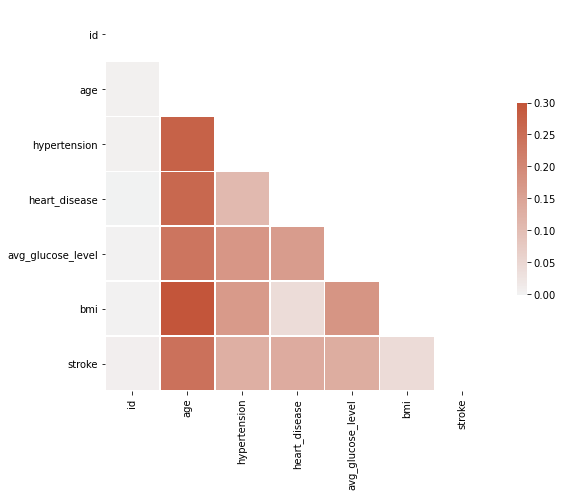

In [374]:
# code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = stroke_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr
save_fig('correlation matrix')

## Feature Extraction and Pipeline

In [327]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# from sklearn.base import BaseEstimator, TransformerMixin

In [328]:
sample_incomplete_rows = stroke_df[stroke_df.isnull().any(axis=1)].head()
sample_incomplete_rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1


In [329]:
stroke_df.isnull().sum() # all null values are BMI

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [330]:
stroke_df_dropped = stroke_df.drop('id', axis=1) # unrelated values

In [331]:
# separate features from the label (i.e., stroke)
stroke_features = stroke_df_dropped.drop("stroke", axis=1)
stroke_labels = stroke_df_dropped["stroke"].copy()

In [422]:
# feature augmentation
stroke_features['hd^2'] = stroke_features['heart_disease'] * stroke_features['heart_disease']
stroke_features['ht_and_hd'] = stroke_features['hypertension'] * stroke_features['heart_disease']

categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
stroke_num = stroke_features.drop(categorical_features, axis=1)

# standardize and impute
numerical_features = list(stroke_num)
ss = StandardScaler().fit(stroke_features[numerical_features].values)
stroke_features[numerical_features] = ss.transform(stroke_features[numerical_features].values)
si = SimpleImputer(strategy='median').fit(stroke_features[['bmi']])
stroke_features['bmi'] = si.transform(stroke_features[['bmi']])
num_transformed = stroke_features.drop(categorical_features, axis=1)

# one-hot encode categorical features
# source: https://stackoverflow.com/questions/54570947/feature-names-from-onehotencoder
ohe = OneHotEncoder()
cat_ohe = pd.DataFrame(ohe.fit_transform(stroke_features[categorical_features]).toarray())
cat_ohe.columns = ohe.get_feature_names(categorical_features)

stroke_prepared = pd.concat([num_transformed, cat_ohe], axis =1).drop_duplicates()
stroke_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   float64
 2   heart_disease                   5110 non-null   float64
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   hd^2                            5110 non-null   float64
 6   ht_and_hd                       5110 non-null   float64
 7   gender_Female                   5110 non-null   float64
 8   gender_Male                     5110 non-null   float64
 9   ever_married_No                 5110 non-null   float64
 10  ever_married_Yes                5110 non-null   float64
 11  work_type_Govt_job              5110 non-null   float64
 12  work_type_Never_worked          51

### Dealing with Imbalanced Dataset

In [333]:
from imblearn.combine import SMOTEENN

In [423]:
X_train, X_test, y_train, y_test = train_test_split(stroke_prepared, stroke_labels, 
                                                    train_size=0.8, random_state=1)

In [391]:
y_train.value_counts()

0    3899
1     189
Name: stroke, dtype: int64

In [335]:
smote_enn = SMOTEENN(random_state=1)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
y_train_resampled.value_counts() # check that the newly sampled data is balanced

1    3766
0    3187
Name: stroke, dtype: int64

## Logistic Regression

In [336]:
import statsmodels.api as sm

In [337]:
import statsmodels.api as sm
lr_stats = sm.OLS(y_train_resampled, X_train_resampled)
lr_results_stats = lr_stats.fit()
print(lr_results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     461.8
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        15:47:03   Log-Likelihood:                -2500.8
No. Observations:                6953   AIC:                             5036.
Df Residuals:                    6936   BIC:                             5152.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
age         

In [339]:
# Deleting columns with p-values > 0.05
X_train_lr = X_train_resampled.drop(['work_type_Never_worked', 'work_type_Private'], axis=1)
X_test_lr = X_test.drop(['work_type_Never_worked', 'work_type_Private'], axis=1)

Full dataset
Accuracy:    0.701566
Precision:   0.154930
Recall:      0.916667
F1 score:    0.265060


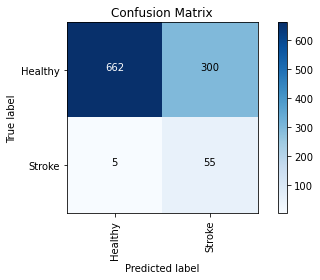

With p > 0.05 dropped
Accuracy:    0.703523
Precision:   0.155807
Recall:      0.916667
F1 score:    0.266344


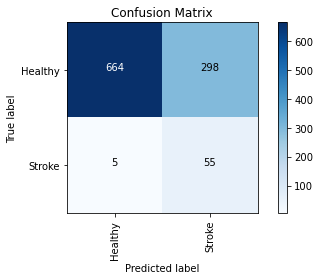

In [416]:
log_reg = LogisticRegression(solver='liblinear', C=0.01, penalty='l2')
log_reg.fit(X_train_resampled, y_train_resampled)
lr_predicted = log_reg.predict(X_test)

print("Full dataset")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, lr_predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, lr_predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, lr_predicted)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test, lr_predicted)))
draw_confusion_matrix(y_test, lr_predicted, ["Healthy", "Stroke"])

log_reg_reduced = LogisticRegression(solver='liblinear', C=0.01, penalty='l2')
log_reg_reduced.fit(X_train_lr, y_train_resampled)
lr_reduced_predicted = log_reg_reduced.predict(X_test_lr)
print("With p > 0.05 dropped")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, lr_reduced_predicted)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, lr_reduced_predicted)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, lr_reduced_predicted)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test, lr_reduced_predicted)))
draw_confusion_matrix(y_test, lr_reduced_predicted, ["Healthy", "Stroke"])

## Principal Component Analysis

In [341]:
from sklearn import decomposition

In [342]:
pca = decomposition.PCA(n_components = 0.95)
lr_reduced = stroke_prepared.drop(['work_type_Never_worked', 'work_type_Private'], axis=1)
stroke_pca = pca.fit_transform(lr_reduced)
print("Original size", lr_reduced.shape)
print("Reduced size", stroke_pca.shape)

Original size (5110, 20)
Reduced size (5110, 11)


In [343]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(stroke_pca, stroke_labels, 
                                                                    train_size=0.8, random_state=1, 
                                                                    stratify=stroke_labels, shuffle=True)

In [344]:
X_train_pca_resampled, y_train_pca_resampled = smote_enn.fit_resample(X_train_pca, y_train_pca)

Accuracy:    0.666341
Precision:   0.107817
Recall:      0.800000
F1 score:    0.190024


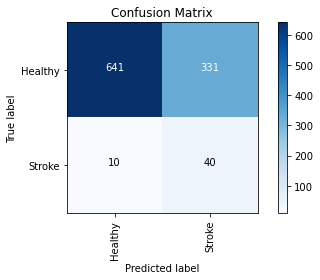

Saving figure LR ROC curve


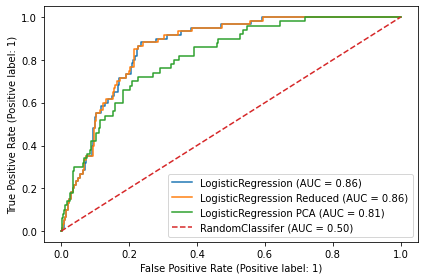

In [397]:
pca_lr = LogisticRegression(solver='liblinear', C=0.01, penalty='l2')
pca_lr.fit(X_train_pca_resampled, y_train_pca_resampled)
pca_lr_pred = pca_lr.predict(X_test_pca)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_pca, pca_lr_pred)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_pca, pca_lr_pred)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_pca, pca_lr_pred)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test_pca, pca_lr_pred)))

draw_confusion_matrix(y_test_pca, pca_lr_pred, ["Healthy", "Stroke"])

lr_disp = metrics.plot_roc_curve(log_reg, X_test, y_test)  
lr_reduced_disp = metrics.plot_roc_curve(log_reg_reduced,X_test_lr,y_test,
                                         ax=lr_disp.ax_, name="LogisticRegression Reduced")
pca_lr_disp = metrics.plot_roc_curve(pca_lr, X_test_pca, y_test_pca,
                                     ax=lr_disp.ax_, name='LogisticRegression PCA')  

plt.plot([0,1],[0,1], linestyle="--", label="RandomClassifer (AUC = 0.50)")
plt.legend() 

save_fig('LR ROC curve')

## Ensemble Methods

In [346]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

###  - AdaBoost

Accuracy:    0.818982
Precision:   0.172775
Recall:      0.550000
F1 score:    0.262948


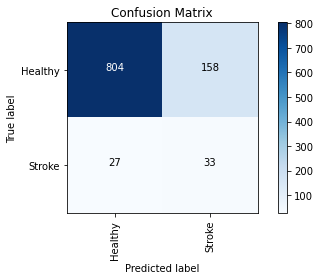

In [399]:
adaboost = AdaBoostClassifier(n_estimators = 90, random_state = 1)
adaboost.fit(X_train_resampled, y_train_resampled)
adaboost_pred = adaboost.predict(X_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, adaboost_pred)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, adaboost_pred)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, adaboost_pred)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test, adaboost_pred)))

draw_confusion_matrix(y_test, adaboost_pred, ["Healthy", "Stroke"])

### - Random Forest

Accuracy:    0.809198
Precision:   0.112299
Recall:      0.420000
F1 score:    0.177215


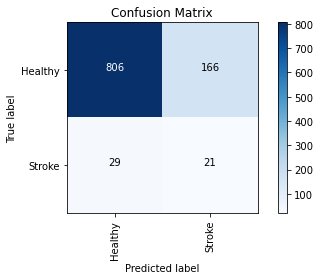

In [398]:
rf = RandomForestClassifier(n_estimators=90,
                            random_state = 1)
rf.fit(X_train_pca_resampled, y_train_pca_resampled)
rf_pred = rf.predict(X_test_pca)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test_pca, rf_pred)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test_pca, rf_pred)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test_pca, rf_pred)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test_pca, rf_pred)))

draw_confusion_matrix(y_test_pca, rf_pred, ["Healthy", "Stroke"])

### - Gradient Boosting

Accuracy:    0.605675
Precision:   0.124726
Recall:      0.950000
F1 score:    0.220503


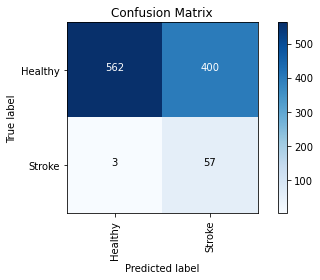

In [350]:
gb = GradientBoostingClassifier(learning_rate=0.01,
                                        n_estimators=40,
                                       loss='deviance',
                                       min_samples_split=0.1,
                                       min_samples_leaf=0.01,
                                       max_features=5,
                                       subsample=0.9,
                                        random_state = 1)
gb.fit(X_train_resampled, y_train_resampled)
gb_pred = gb.predict(X_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, gb_pred)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, gb_pred)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, gb_pred)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test, gb_pred)))

draw_confusion_matrix(y_test, gb_pred, ["Healthy", "Stroke"])

Saving figure Gradient Boosting max_features Tuning


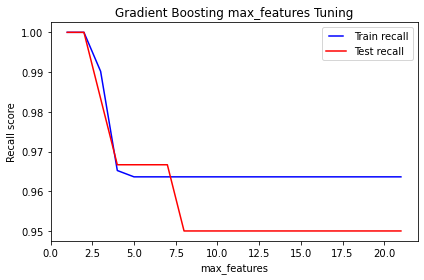

In [415]:
# code referenced from
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

# each parameter was manually tested, because I didn't know how to automate it...
# this current code shows the process for optimizing max_features, where all the 
# previous features have already been optimized one-by-one
parameter_space = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
    'n_estimators': range(10,101,10),
    'loss': ['deviance','exponential'],
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features': list(range(1,X_train.shape[1])),
    'subsample': np.linspace(0.1, 1.0, 10, endpoint=True)
}

parameter = 'max_features'
values = parameter_space[parameter]
train_results = []
test_results = []
for n in values:
    model = GradientBoostingClassifier(learning_rate=0.01,
                                        n_estimators=40,
                                       loss='deviance',
                                       min_samples_split=0.3,
                                       min_samples_leaf=0.3,
                                       max_features=n,
                                        random_state = 1)
    model.fit(X_train_resampled, y_train_resampled)

    train_pred = model.predict(X_train_resampled)
    score = metrics.recall_score(y_train_resampled, train_pred)
    train_results.append(score)

    y_pred = model.predict(X_test)
    score = metrics.recall_score(y_test, y_pred)
    test_results.append(score)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(values, train_results, 'b', label='Train recall')
line2, = plt.plot(values, test_results, 'r', label='Test recall')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Recall score')
plt.xlabel(parameter)
plt.title("Gradient Boosting " +str(parameter) +" Tuning")
save_fig("Gradient Boosting " +str(parameter) +" Tuning")

## Neural Net

In [352]:
from sklearn.neural_network import MLPClassifier

Accuracy:    0.818004
Precision:   0.191176
Recall:      0.650000
F1 score:    0.295455


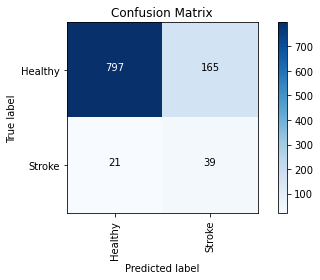

In [411]:
sk_nn = MLPClassifier(random_state=1,
                      learning_rate_init=0.1,
                      hidden_layer_sizes=(200,200,200),
                      activation='tanh',
                      alpha=0.0005,
                      learning_rate='adaptive')
sk_nn.fit(X_train_resampled, y_train_resampled)
sk_nn_pred = sk_nn.predict(X_test)

print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, sk_nn_pred)))
print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, sk_nn_pred)))
print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, sk_nn_pred)))
print("%-12s %f" % ('F1 score:', metrics.f1_score(y_test, sk_nn_pred)))

draw_confusion_matrix(y_test, sk_nn_pred, ["Healthy", "Stroke"])

Saving figure Neural Net alpha Tuning


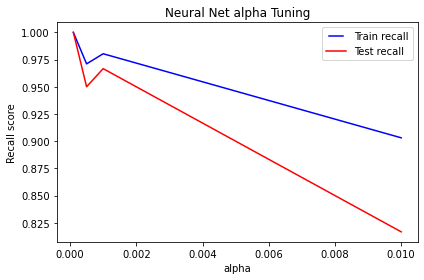

In [414]:
parameter_space = {
    'hidden_layer_sizes': [(200,200,200),(50,200,50)],
    'activation': ['tanh', 'relu', 'logistic'],
    'alpha': [0.0001, 0.0005, 0.001, 0.01],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.1, 0.05, 0.01, 0.005, 0.001],
}
    
parameter = 'alpha'
values = parameter_space[parameter]
train_results = []
test_results = []
for n in values:
    model = MLPClassifier(random_state=1,
                          learning_rate_init=0.1,
                      hidden_layer_sizes=(200,200,200),
                      activation='tanh',
                         alpha=n)
    model.fit(X_train_resampled, y_train_resampled)

    train_pred = model.predict(X_train_resampled)
    score = metrics.recall_score(y_train_resampled, train_pred)
    train_results.append(score)

    y_pred = model.predict(X_test)
    score = metrics.recall_score(y_test, y_pred)
    test_results.append(score)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(values, train_results, 'b', label='Train recall')
line2, = plt.plot(values, test_results, 'r', label='Test recall')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Recall score')
plt.xlabel(parameter)
plt.title("Neural Net " +str(parameter) +" Tuning")
save_fig("Neural Net " +str(parameter) +" Tuning")

## Cross Validation

In [419]:
models = [pca_lr, adaboost, rf, gb, sk_nn]
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
reset_y_train_pca = y_train_pca.reset_index(drop=True)


'''
I customized the way I did cross validation, since it should reflect how
I've been training and evaluating models thus far, which is:
    - train on resampled data
    - test on original distribution
So, I used StratifiedShuffleSplit to split the original training set. Then, 
I resampled the inner training set (from the SSS).
'''
recall_scores = {}
print("---------------------")
for model in models:
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    print("---------------------")
    print("Model:", model)
    for train_index, test_index in sss.split(X_train_pca, reset_y_train_pca):
        # form training and validation sets for CV
        cv_X_train, cv_X_test = X_train_pca[train_index], X_train_pca[test_index]
        cv_y_train, cv_y_test = reset_y_train_pca[train_index], reset_y_train_pca[test_index]
        
        # resample the training set to account for class imbalance
        cv_X_train_resampled, cv_y_train_resampled = smote_enn.fit_resample(cv_X_train, cv_y_train)
        
        # fit and predict
        model.fit(cv_X_train_resampled, cv_y_train_resampled)
        pred = model.predict(cv_X_test)
        
        # get metrics
        accuracies.append(metrics.accuracy_score(cv_y_test,pred))
        precisions.append(metrics.precision_score(cv_y_test,pred))
        recalls.append(metrics.recall_score(cv_y_test,pred))
        f1_scores.append(metrics.f1_score(cv_y_test,pred))
    print("%-12s %f" % ('Average Accuracy:', np.array(accuracies).mean()))
    print("%-12s %f" % ('Average Precision:', np.array(precisions).mean()))
    print("%-12s %f" % ('Average Recall:', np.array(recalls).mean()))
    print("%-12s %f" % ('Average F1 score:', np.array(f1_scores).mean()))
    print("---------------------")
    recall_scores[model] = np.array(recalls).mean()
print("---------------------")
Keymax = max(recall_scores, key=recall_scores.get)
print("The best performing model is", Keymax, "with recall of", recall_scores[Keymax])

---------------------
---------------------
Model: LogisticRegression(C=0.01, solver='liblinear')
Average Accuracy: 0.684352
Average Precision: 0.118923
Average Recall: 0.850000
Average F1 score: 0.208600
---------------------
---------------------
Model: AdaBoostClassifier(n_estimators=90, random_state=1)
Average Accuracy: 0.749756
Average Precision: 0.131069
Average Recall: 0.730000
Average F1 score: 0.222151
---------------------
---------------------
Model: RandomForestClassifier(n_estimators=90, random_state=1)
Average Accuracy: 0.829218
Average Precision: 0.136499
Average Recall: 0.470000
Average F1 score: 0.211378
---------------------
---------------------
Model: GradientBoostingClassifier(learning_rate=0.01, max_features=5,
                           min_samples_leaf=0.01, min_samples_split=0.1,
                           n_estimators=40, random_state=1, subsample=0.9)
Average Accuracy: 0.647555
Average Precision: 0.110706
Average Recall: 0.880000
Average F1 score: 0.196533
--